# Chapter 11. God Spiked the Integers

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax, vmap
from jax.nn import softmax
import jax.numpy as np
from jax.random import PRNGKey
from jax.scipy.special import expit

import numpyro as npyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, SVI, log_likelihood
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")
npyro.set_host_device_count(4)

### Code 11.1

In [2]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees

### Code 11.2

In [3]:
d["treatment"] = d.prosoc_left + 2 * d.condition

### Code 11.3

In [4]:
d.reset_index().groupby(
    ["condition", "prosoc_left", "treatment"]).count()["index"]

condition  prosoc_left  treatment
0          0            0            126
           1            1            126
1          0            2            126
           1            3            126
Name: index, dtype: int64

### Code 11.4

In [5]:
def model(pulled_left=None):
    a = npyro.sample("a", dist.Normal(0, 10))
    logit_p = a
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m11_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m11_1, optim.Adam(1), AutoContinuousELBO(),
          pulled_left=d.pulled_left.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p11_1 = svi.get_params(state)

### Code 11.5

In [6]:
prior = Predictive(m11_1.model, num_samples=10000).get_samples(PRNGKey(1999))

### Code 11.6

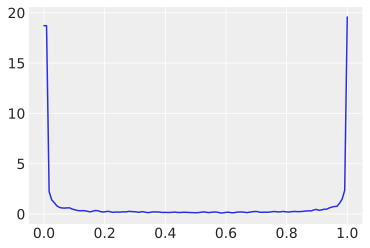

In [7]:
p = expit(prior["a"])
az.plot_kde(p, bw=0.3);

### Code 11.7

In [8]:
def model(treatment, pulled_left=None):
    a = npyro.sample("a", dist.Normal(0, 1.5))
    b = npyro.sample("b", dist.Normal(0, 10), sample_shape=(4,))
    logit_p = a + b[treatment]
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m11_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m11_2, optim.Adam(1), AutoContinuousELBO(),
          treatment=d.treatment.values, pulled_left=d.pulled_left.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p11_2 = svi.get_params(state)
prior = Predictive(model, num_samples=int(1e4)).get_samples(
    PRNGKey(1999), treatment=0, pulled_left=0)
p = vmap(lambda k: expit(prior["a"] + prior["b"][:, k]), 0, 1)(np.arange(4))

### Code 11.8

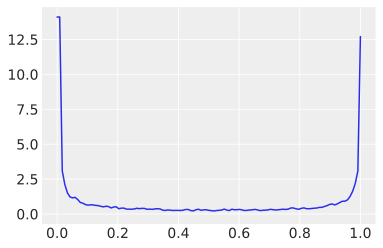

In [9]:
az.plot_kde(np.abs(p[:, 0] - p[:, 1]), bw=0.3);

### Code 11.9

In [10]:
def model(treatment, pulled_left=None):
    a = npyro.sample("a", dist.Normal(0, 1.5))
    b = npyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a + b[treatment]
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m11_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m11_3, optim.Adam(1), AutoContinuousELBO(),
          treatment=d.treatment.values, pulled_left=d.pulled_left.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p11_3 = svi.get_params(state)
prior = Predictive(model, num_samples=int(1e4)).get_samples(
    PRNGKey(1999), treatment=0, pulled_left=0)
p = vmap(lambda k: expit(prior["a"] + prior["b"][:, k]), 0, 1)(np.arange(4))
np.mean(np.abs(p[:, 0] - p[:, 1]))

DeviceArray(0.09770478, dtype=float32)

### Code 11.10

In [11]:
# prior trimmed data list
dat_list = {"pulled_left": d.pulled_left.values,
            "actor": d.actor.values - 1,
            "treatment": d.treatment.values}

# particles in 11-dimensional space
def model(actor, treatment, pulled_left=None, link=False):
    a = npyro.sample("a", dist.Normal(0, 1.5), sample_shape=(7,))
    b = npyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a[actor] + b[treatment]
    if link:
        p = expit(logit_p)
        npyro.sample("p", dist.Delta(p), obs=p)
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m11_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_4.run(PRNGKey(0), **dat_list)
m11_4.print_summary(0.89)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.45      0.33     -0.45     -0.96      0.11    691.70      1.00
      a[1]      3.88      0.76      3.83      2.67      5.02   2092.28      1.00
      a[2]     -0.76      0.33     -0.75     -1.26     -0.23    690.74      1.00
      a[3]     -0.75      0.34     -0.75     -1.33     -0.26    724.76      1.00
      a[4]     -0.45      0.33     -0.47     -0.97      0.08    649.59      1.00
      a[5]      0.48      0.34      0.47     -0.09      1.00    760.40      1.00
      a[6]      1.95      0.42      1.94      1.27      2.58    941.57      1.00
      b[0]     -0.03      0.29     -0.03     -0.51      0.40    634.56      1.00
      b[1]      0.48      0.30      0.48     -0.01      0.93    658.52      1.00
      b[2]     -0.38      0.29     -0.38     -0.81      0.12    657.59      1.00
      b[3]      0.38      0.29      0.38     -0.09      0.84    598.39      1.00




### Code 11.11

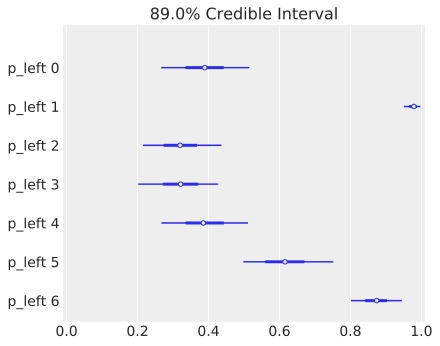

In [12]:
post = m11_4.get_samples(group_by_chain=True)
p_left = expit(post["a"])
az.plot_forest({"p_left": p_left}, combined=True, credible_interval=0.89)
plt.gca().set(xlim=(-0.01, 1.01));

### Code 11.12

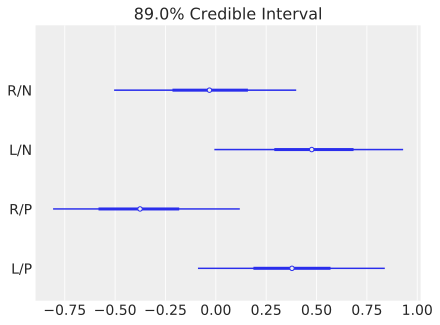

In [13]:
labs = ["R/N", "L/N", "R/P", "L/P"]
az.plot_forest(m11_4.get_samples(group_by_chain=True), combined=True,
               var_names="b", credible_interval=0.89)
plt.gca().set_yticklabels(labs[::-1]);

### Code 11.13

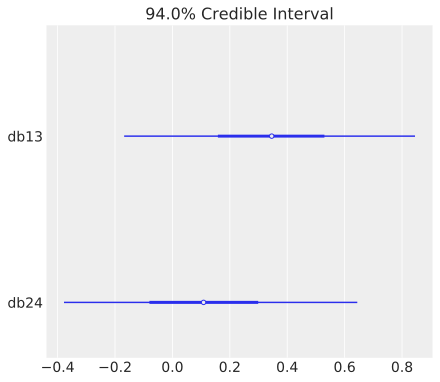

In [14]:
diffs = {"db13": post["b"][..., 0] - post["b"][..., 2],
         "db24": post["b"][..., 1] - post["b"][..., 3]}
az.plot_forest(diffs, combined=True);

### Code 11.14

In [15]:
pl = d.groupby(["actor", "treatment"])["pulled_left"].mean().unstack()
pl.iloc[0, :]

treatment
0    0.333333
1    0.500000
2    0.277778
3    0.555556
Name: 1, dtype: float64

### Code 11.15

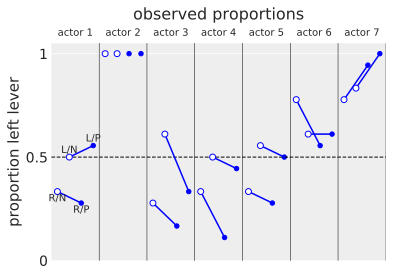

In [16]:
ax = plt.subplot(xlim=(0.5, 28.5), ylim=(0, 1.05), xlabel="",
                 ylabel="proportion left lever", xticks=[])
plt.yticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
ax.axhline(0.5, c="k", lw=1, ls="--")
for j in range(1, 8):
    ax.axvline((j - 1) * 4 + 4.5, c="k", lw=0.5)
for j in range(1, 8):
    ax.annotate("actor {}".format(j), ((j - 1) * 4 + 2.5, 1.1),
                ha="center", va="center", annotation_clip=False)
for j in onp.delete(range(1, 8), 1):
    ax.plot((j - 1) * 4 + np.array([1, 3]), pl.loc[j, [0, 2]], "b")
    ax.plot((j - 1) * 4 + np.array([2, 4]), pl.loc[j, [1, 3]], "b")
x = np.arange(1, 29).reshape(7, 4)
ax.scatter(x[:, [0, 1]].reshape(-1), pl.values[:, [0, 1]].reshape(-1),
           edgecolor="b", facecolor="w", zorder=3)
ax.scatter(x[:, [2, 3]].reshape(-1), pl.values[:, [2, 3]].reshape(-1),
           marker=".", c="b", s=80)
yoff = 0.01
ax.annotate("R/N", (1, pl.loc[1, 0] - yoff), ha="center", va="top")
ax.annotate("L/N", (2, pl.loc[1, 1] + yoff), ha="center", va="bottom")
ax.annotate("R/P", (3, pl.loc[1, 2] - yoff), ha="center", va="top")
ax.annotate("L/P", (4, pl.loc[1, 3] + yoff), ha="center", va="bottom")
ax.set_title("observed proportions\n");

### Code 11.16

In [17]:
dat = {"actor": np.repeat(np.arange(7), 4),
       "treatment": np.tile(np.arange(4), 7)}
p_post = Predictive(m11_4.sampler.model, m11_4.get_samples()).get_samples(
    PRNGKey(1), return_sites=["p"], link=True, **dat)["p"]
p_mu = np.mean(p_post, 0)
p_ci = np.percentile(p_post, q=(4.5, 95.5), axis=0)

### Code 11.17

In [18]:
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

### Code 11.18

In [19]:
dat_list2 = {"pulled_left": d.pulled_left.values,
             "actor": d.actor.values - 1,
             "side": d.side.values,
             "cond": d.cond.values}

def model(actor, side, cond, pulled_left=None):
    a = npyro.sample("a", dist.Normal(0, 1.5), sample_shape=(7,))
    bs = npyro.sample("bs", dist.Normal(0, 0.5), sample_shape=(2,))
    bc = npyro.sample("bc", dist.Normal(0, 0.5), sample_shape=(2,))
    logit_p = a[actor] + bs[side] + bc[cond]
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m11_5 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_5.run(PRNGKey(0), **dat_list2)

### Code 11.19

In [20]:
az.compare({"m11.5": az.from_numpyro(m11_5), "m11.4": az.from_numpyro(m11_4)},
           ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.5,0,530.487,7.60204,0,0.6687,18.3558,0,False,deviance
m11.4,1,531.973,8.34778,1.4862,0.3313,18.2289,1.31702,False,deviance


### Code 11.20

In [21]:
post = m11_4.get_samples()
post["log_lik"] = log_likelihood(
    m11_4.sampler.model, post, **dat_list)["pulled_left"]
{k: v.shape for k, v in post.items()}

{'a': (2000, 7), 'b': (2000, 4), 'log_lik': (2000, 504)}

### Code 11.21

In [22]:
def m11_4_pe_code(params, log_lik=False):
    a_logprob = np.sum(dist.Normal(0, 1.5).log_prob(params["a"]))
    b_logprob = np.sum(dist.Normal(0, 0.5).log_prob(params["b"]))
    logit_p = (
        params["a"][dat_list["actor"]] + params["b"][dat_list["treatment"]])
    pulled_left_logprob = dist.Binomial(logits=logit_p).log_prob(
        dat_list["pulled_left"])
    if log_lik:
        return pulled_left_logprob
    return -(a_logprob + b_logprob + np.sum(pulled_left_logprob))

m11_4_pe = MCMC(NUTS(potential_fn=m11_4_pe_code), 500, 500, num_chains=4)
init_params = {"a": np.zeros((4, 7)), "b": np.zeros((4, 4))}
m11_4_pe.run(PRNGKey(0), init_params=init_params)
log_lik = vmap(lambda p: m11_4_pe_code(p, log_lik=True))(
    m11_4_pe.get_samples())
m11_4_pe_az = az.from_numpyro(m11_4_pe)
m11_4_pe_az.sample_stats["log_likelihood"] = (
    ("chain", "draw", "log_lik"), np.reshape(log_lik, (4, 500, -1)))
az.compare({"m11.4_pe": m11_4_pe_az, "m11.4": az.from_numpyro(m11_4)})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m11.4,0,531.969,8.34589,0,0.507161,18.6693,0,False,deviance
m11.4_pe,1,532.033,8.34947,0.0638615,0.492839,18.6359,0.138737,False,deviance


### Code 11.22

In [23]:
post = m11_4.get_samples()
np.mean(np.exp(post["b"][:, 3] - post["b"][:, 1]))

DeviceArray(0.9336071, dtype=float32)

### Code 11.23

In [24]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees
d["treatment"] = d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1
d_aggregated = d.groupby(
    ["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)

### Code 11.24

In [25]:
dat = dict(zip(d_aggregated.columns, d_aggregated.values.T))

def model(actor, treatment, left_pulls):
    a = npyro.sample("a", dist.Normal(0, 1.5), sample_shape=(7,))
    b = npyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a[actor] + b[treatment]
    npyro.sample("left_pulls", dist.Binomial(18, logits=logit_p),
                 obs=left_pulls)

m11_6 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_6.run(PRNGKey(0), actor=dat["actor"] - 1, treatment=dat["treatment"],
          left_pulls=dat["left_pulls"])

### Code 11.25

In [26]:
try:
    az.compare({"m11.6": az.from_numpyro(m11_6),
                "m11.4": az.from_numpyro(m11_4)})
except Exception as e:
    warnings.warn("\n{}: {}".format(type(e).__name__, e))

See http://arxiv.org/abs/1507.04544 for details
ValueError: The number of observations should be the same across all models


### Code 11.26

In [27]:
# deviance of aggregated 6-in-9
print(-2 * dist.Binomial(9, 0.2).log_prob(6))
# deviance of dis-aggregated
print(-2 * np.sum(
    dist.Bernoulli(0.2).log_prob(np.array([1, 1, 1, 1, 1, 1, 0, 0, 0]))))

11.790482
20.652117


### Code 11.27

In [28]:
k = az.loo(az.from_numpyro(m11_6), pointwise=True).pareto_k.values
k

array([0.25774329, 0.37528993, 0.4269473 , 0.5592152 , 0.44369084,
       0.66189809, 0.41027456, 0.37874972, 0.10209645, 0.6135099 ,
       0.43214034, 0.41099818, 0.37918333, 0.4142555 , 0.44928758,
       0.45737763, 0.32268111, 0.53664805, 0.51940265, 0.40323896,
       0.55213717, 0.5055023 , 0.23829184, 0.43941906, 0.40040616,
       0.21427117, 0.39895188, 0.468949  ])

### Code 11.28

In [29]:
UCBadmit = pd.read_csv("../data/UCBadmit.csv", sep=";")
d = UCBadmit

### Code 11.29

In [30]:
d["gid"] = (d["applicant.gender"] != "male").astype(int)

def model(gid, applications, admit=None):
    a = npyro.sample("a", dist.Normal(0, 1.5), sample_shape=(2,))
    logit_p = a[gid]
    npyro.sample("admit", dist.Binomial(applications, logits=logit_p),
                 obs=admit)

m11_7 = AutoLaplaceApproximation(model)
svi = SVI(model, m11_7, optim.Adam(1), AutoContinuousELBO(), gid=d.gid.values,
          applications=d.applications.values, admit=d.admit.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p11_7 = svi.get_params(state)
post = m11_7.sample_posterior(PRNGKey(1), p11_7, sample_shape=(1000,))
summary(post, 0.89, False)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.22      0.04     -0.22     -0.28     -0.16    995.06      1.00
      a[1]     -0.83      0.05     -0.83     -0.90     -0.74   1002.75      1.00




### Code 11.30

In [31]:
post = m11_7.sample_posterior(PRNGKey(1), p11_7, sample_shape=(1000,))
diff_a = post["a"][:, 0] - post["a"][:, 1]
diff_p = expit(post["a"][:, 0]) - expit(post["a"][:, 1])
summary({"diff_a": diff_a, "diff_p": diff_p}, 0.89, False)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
    diff_a      0.61      0.06      0.61      0.51      0.70    960.87      1.00
    diff_p      0.14      0.01      0.14      0.12      0.16    962.74      1.00




### Code 11.31

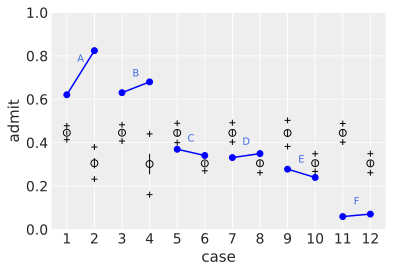

In [32]:
post = m11_7.sample_posterior(PRNGKey(1), p11_7, sample_shape=(1000,))
admit_pred = Predictive(m11_7.model, post).get_samples(
    PRNGKey(2), gid=d.gid.values, applications=d.applications.values)["admit"]
admit_rate = admit_pred / d.applications.values
plt.errorbar(range(1, 13), np.mean(admit_rate, 0), np.std(admit_rate, 0) / 2,
             fmt="o", c="k", mfc="none", ms=7, elinewidth=1)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+")
# draw lines connecting points from same dept
for i in range(1, 7):
    x = 1 + 2 * (i - 1)
    y1 = d.admit.iloc[x - 1] / d.applications.iloc[x - 1]
    y2 = d.admit.iloc[x] / d.applications.iloc[x]
    plt.plot((x, x + 1), (y1, y2), "bo-")
    plt.annotate(d.dept.iloc[x], (x + 0.5, (y1 + y2) / 2 + 0.05),
                 ha="center", color="royalblue")
plt.gca().set(ylim=(0, 1), xticks=range(1, 13), ylabel="admit", xlabel="case");

### Code 11.32

In [33]:
d["dept_id"] = np.repeat(np.arange(6), 2)

def model(gid, dept_id, applications, admit=None):
    a = npyro.sample("a", dist.Normal(0, 1.5), sample_shape=(2,))
    delta = npyro.sample("delta", dist.Normal(0, 1.5), sample_shape=(6,))
    logit_p = a[gid] + delta[dept_id]
    npyro.sample("admit", dist.Binomial(applications, logits=logit_p),
                 obs=admit)

m11_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m11_8, optim.Adam(0.3), AutoContinuousELBO(),
          gid=d.gid.values, dept_id=d.dept_id.values,
          applications=d.applications.values, admit=d.admit.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p11_8 = svi.get_params(state)
post = m11_8.sample_posterior(PRNGKey(1), p11_8, sample_shape=(1000,))
summary(post, 0.89, False)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.52      0.55     -0.52     -1.50      0.27    870.38      1.00
      a[1]     -0.43      0.55     -0.45     -1.36      0.39    876.13      1.00
  delta[0]      1.10      0.55      1.10      0.13      1.92    874.26      1.00
  delta[1]      1.06      0.55      1.06      0.10      1.86    879.88      1.00
  delta[2]     -0.15      0.55     -0.15     -0.99      0.75    874.70      1.00
  delta[3]     -0.19      0.55     -0.18     -1.02      0.74    868.10      1.00
  delta[4]     -0.63      0.56     -0.62     -1.39      0.40    861.47      1.00
  delta[5]     -2.18      0.56     -2.16     -3.02     -1.21    916.95      1.00




### Code 11.33

In [34]:
post = m11_8.sample_posterior(PRNGKey(1), p11_8, sample_shape=(1000,))
diff_a = post["a"][:, 0] - post["a"][:, 1]
diff_p = expit(post["a"][:, 0]) - expit(post["a"][:, 1])
summary({"diff_a": diff_a, "diff_p": diff_p}, 0.89, False)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
    diff_a     -0.09      0.08     -0.09     -0.22      0.05    987.42      1.00
    diff_p     -0.02      0.02     -0.02     -0.05      0.01   1000.28      1.00




### Code 11.34

In [35]:
pg = np.stack(list(map(
    lambda k: np.divide(d.applications[d.dept_id == k].values,
                        d.applications[d.dept_id == k].sum()),
    range(6))), axis=0).T
pg = pd.DataFrame(pg, index=["male", "female"], columns=d.dept.unique())
pg.round(2)

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


### Code 11.35

In [36]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.arange(1, 4)  # expected income of each career
score = 0.5 * income  # scores for each career, based on income
# next line converts scores to probabilities
p = softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = onp.repeat(np.nan, N)  # empty vector of choices for each individual
# sample chosen career for each individual
for i in range(N):
    career[i] = dist.Categorical(probs=p).sample(PRNGKey(i))
career = career.astype(int)

### Code 11.36

In [37]:
# fit the model, using dist.Categorical and softmax link
def model(career):
    b = npyro.sample("b", dist.Normal(0, 5))
    s2 = b * 2  # linear model for event type 2
    s3 = b * 3  # linear model for event type 3
    npyro.sample("career", dist.Categorical(softmax(np.stack([b, s2, s3]))),
                 obs=career)

m10_16 = AutoLaplaceApproximation(model)
svi = SVI(model, m10_16, optim.Adam(1), AutoContinuousELBO(), career=career)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p10_16 = svi.get_params(state)

### Code 11.37

In [38]:
N = 100
# simulate family incomes for each individual
family_income = dist.Uniform().sample(PRNGKey(0), (N,))
# assign a unique coefficient for each type of event
b = np.arange(1, -2, -1)
career = onp.repeat(np.nan, N)  # empty vector of choices for each individual
for i in range(N):
    score = 0.5 * np.arange(1, 4) + b * family_income[i]
    p = softmax(score)
    career[i] = dist.Categorical(probs=p).sample(PRNGKey(i + 1))
career = career.astype(int)

def model(career, family_income):
    a2, a3, b2, b3 = npyro.sample("a2_a3_b2_b3", dist.Normal(0, 5),
                                  sample_shape=(4,))
    s2 = a2 + b2 * family_income
    s3 = a3 + b3 * family_income
    npyro.sample("career", dist.Categorical(
        softmax(np.stack([np.zeros(N), s2, s3], -1))), obs=career)

m10_17 = AutoLaplaceApproximation(model)
svi = SVI(model, m10_17, optim.Adam(1), AutoContinuousELBO(),
          career=career, family_income=family_income)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p10_17 = svi.get_params(state)

### Code 11.38

In [39]:
y = dist.Binomial(1000, 1 / 1000).sample(PRNGKey(0), (int(1e5),))
np.mean(y), np.var(y)

(DeviceArray(1.00491, dtype=float32), DeviceArray(0.99952585, dtype=float32))

### Code 11.39

In [40]:
Kline = pd.read_csv("../data/Kline.csv", sep=";")
d = Kline
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


### Code 11.40

In [41]:
d["P"] = d.population.pipe(onp.log).pipe(lambda x: (x - x.mean()) / x.std())
d["contact_id"] = (d.contact == "high").astype(int)

### Code 11.41

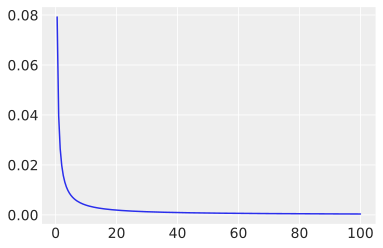

In [42]:
x = np.linspace(0, 100, 200)
plt.plot(x, np.exp(dist.LogNormal(0, 10).log_prob(x)));

### Code 11.42

In [43]:
a = dist.Normal(0, 10).sample(PRNGKey(0), (int(1e4),))
lambda_ = np.exp(a)
np.mean(lambda_)

DeviceArray(1.172647e+12, dtype=float32)

### Code 11.43

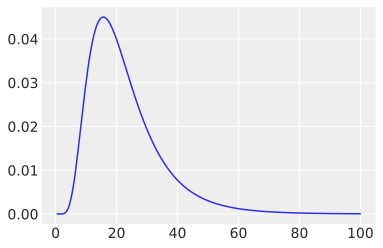

In [44]:
x = np.linspace(0, 100, 200)
plt.plot(x, np.exp(dist.LogNormal(3, 0.5).log_prob(x)));

### Code 11.44

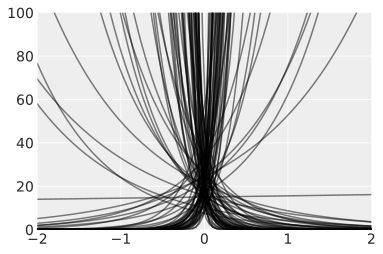

In [45]:
N = 100
a = dist.Normal(3, 0.5).sample(PRNGKey(0), (N,))
b = dist.Normal(0, 10).sample(PRNGKey(1), (N,))
plt.subplot(xlim=(-2, 2), ylim=(0, 100))
x = np.linspace(-2, 2, 100)
for i in range(N):
    plt.plot(x, np.exp(a[i] + b[i] * x), c="k", alpha=0.5)

### Code 11.45

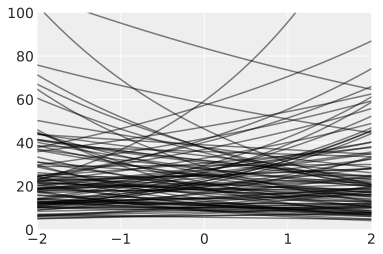

In [46]:
with npyro.handlers.seed(rng=10):
    N = 100
    a = npyro.sample("a", dist.Normal(3, 0.5), sample_shape=(N,))
    b = npyro.sample("a", dist.Normal(0, 0.2), sample_shape=(N,))
    plt.subplot(xlim=(-2, 2), ylim=(0, 100))
    x = np.linspace(-2, 2, 100)
    for i in range(N):
        plt.plot(x, np.exp(a[i] + b[i] * x), c="k", alpha=0.5)

### Code 11.46

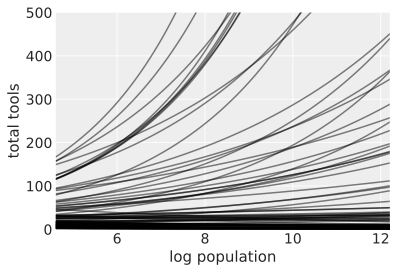

In [47]:
x_seq = np.linspace(np.log(100), np.log(200000), num=100)
lambda_ = vmap(lambda x: np.exp(a + b * x), out_axes=1)(x_seq)
plt.subplot(xlim=(np.min(x_seq).item(), np.max(x_seq).item()), ylim=(0, 500),
            xlabel="log population", ylabel="total tools")
for i in range(N):
    plt.plot(x_seq, lambda_[i], c="k", alpha=0.5)

### Code 11.47

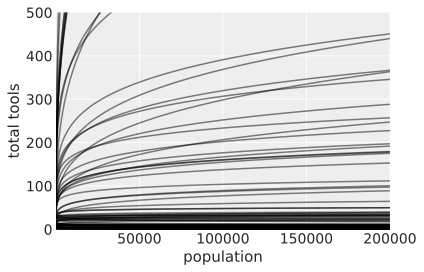

In [48]:
plt.subplot(xlim=(np.min(np.exp(x_seq)).item(), np.max(np.exp(x_seq)).item()),
            ylim=(0, 500), xlabel="population", ylabel="total tools")
for i in range(N):
    plt.plot(np.exp(x_seq), lambda_[i], c="k", alpha=0.5)

### Code 11.48

In [49]:
dat = dict(T=d.total_tools.values, P=d.P.values, cid=d.contact_id.values)

# intercept only
def model(T=None, link=False):
    a = npyro.sample("a", dist.Normal(3, 0.5))
    lambda_ = np.exp(a)
    if link:
        npyro.sample("lambda", dist.Delta(lambda_), obs=lambda_)
    npyro.sample("T", dist.Poisson(lambda_), obs=T)

m11_9 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_9.run(PRNGKey(0), dat["T"])

# interaction model
def model(cid, P, T=None, link=False):
    a = npyro.sample("a", dist.Normal(3, 0.5), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.2), sample_shape=(2,))
    lambda_ = np.exp(a[cid] + b[cid] * P)
    if link:
        npyro.sample("lambda", dist.Delta(lambda_), obs=lambda_)
    npyro.sample("T", dist.Poisson(lambda_), obs=T)

m11_10 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_10.run(PRNGKey(0), **dat)

### Code 11.49

In [50]:
az.compare({"m11.9": az.from_numpyro(m11_9),
            "m11.10": az.from_numpyro(m11_10)}, ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.10,0,84.6568,6.66049,0,0.99744,30.1295,0,True,deviance
m11.9,1,141.042,7.98181,56.3848,0.00255982,11.2981,31.4756,True,deviance


### Code 11.50

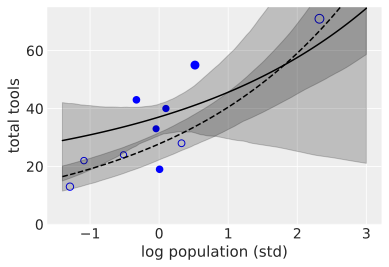

In [51]:
k = az.loo(az.from_numpyro(m11_10), pointwise=True).pareto_k.values
cex = 1 + (k - np.min(k)) / (np.max(k) - np.min(k))
plt.scatter(dat["P"], dat["T"], s=40 * cex,
            edgecolors=["none" if i == 1 else "b" for i in dat["cid"]],
            facecolors=["none" if i == 0 else "b" for i in dat["cid"]])
plt.gca().set(xlabel="log population (std)", ylabel="total tools",
              ylim=(0, 75))

# set up the horizontal axis values to compute predictions at
ns = 100
P_seq = np.linspace(-1.4, 3, num=ns)

# predictions for cid=0 (low contact)
lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples()).get_samples(
    PRNGKey(1), P=P_seq, cid=0, link=True)["lambda"]
lmu = np.mean(lambda_, 0)
lci = np.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(P_seq, lmu, "k--", lw=1.5)
plt.fill_between(P_seq, lci[0], lci[1], color="k", alpha=0.2)

# predictions for cid=1 (high contact)
lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples()).get_samples(
    PRNGKey(1), P=P_seq, cid=1, link=True)["lambda"]
lmu = np.mean(lambda_, 0)
lci = np.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(P_seq, lmu, "k", lw=1.5)
plt.fill_between(P_seq, lci[0], lci[1], color="k", alpha=0.2);

### Code 11.51

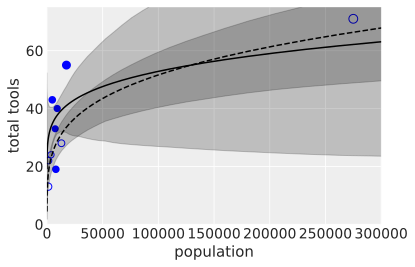

In [52]:
cex = 1 + (k - np.min(k)) / (np.max(k) - np.min(k))
plt.scatter(d.population, d.total_tools, s=40 * cex,
            edgecolors=["none" if i == 1 else "b" for i in dat["cid"]],
            facecolors=["none" if i == 0 else "b" for i in dat["cid"]])
plt.gca().set(xlabel="population", ylabel="total tools",
              xlim=(0, 300000), ylim=(0, 75))

ns = 100
P_seq = np.linspace(-5, 3, num=ns)
# 1.53 is sd of log(population)
# 9 is mean of log(population)
pop_seq = np.exp(P_seq * 1.53 + 9)

lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples()).get_samples(
    PRNGKey(1), P=P_seq, cid=0, link=True)["lambda"]
lmu = np.mean(lambda_, 0)
lci = np.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(pop_seq, lmu, "k--", lw=1.5)
plt.fill_between(pop_seq, lci[0], lci[1], color="k", alpha=0.2)

lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples()).get_samples(
    PRNGKey(1), P=P_seq, cid=1, link=True)["lambda"]
lmu = np.mean(lambda_, 0)
lci = np.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(pop_seq, lmu, "k", lw=1.5)
plt.fill_between(pop_seq, lci[0], lci[1], color="k", alpha=0.2);

### Code 11.52

In [53]:
dat2 = dict(T=d.total_tools.values, P=d.population.values,
            cid=d.contact_id.values)

def model(cid, P, T):
    a = npyro.sample("a", dist.Normal(1, 1), sample_shape=(2,))
    b = npyro.sample("b", dist.Exponential(1), sample_shape=(2,))
    g = npyro.sample("g", dist.Exponential(1))
    lambda_ = np.exp(a[cid]) * np.power(P, b[cid]) / g
    npyro.sample("T", dist.Poisson(lambda_), obs=T)

m11_11 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_11.run(PRNGKey(0), **dat2)

### Code 11.53

In [54]:
num_days = 30
y = dist.Poisson(1.5).sample(PRNGKey(0), (num_days,))

### Code 11.54

In [55]:
num_weeks = 4
y_new = dist.Poisson(0.5 * 7).sample(PRNGKey(0), (num_weeks,))

### Code 11.55

In [56]:
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))

### Code 11.56

In [57]:
# compute the offset
d["log_days"] = d.days.pipe(onp.log)

def model(log_days, monastery, y):
    a = npyro.sample("a", dist.Normal(0, 1))
    b = npyro.sample("b", dist.Normal(0, 1))
    lambda_ = np.exp(log_days + a + b * monastery)
    npyro.sample("T", dist.Poisson(lambda_), obs=y)

m11_12 = MCMC(NUTS(model), 500, 500)
m11_12.run(PRNGKey(0), d.log_days.values, d.monastery.values, d.y.values)

sample: 100%|██████████| 1000/1000 [00:03<00:00, 253.29it/s, 7 steps of size 7.73e-01. acc. prob=0.91]


### Code 11.57

In [58]:
post = m11_12.get_samples()
lambda_old = np.exp(post["a"])
lambda_new = np.exp(post["a"] + post["b"])
summary(dict(lambda_old=lambda_old, lambda_new=lambda_new), 0.89, False)



                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  lambda_new      0.56      0.15      0.54      0.34      0.79    450.45      1.00
  lambda_old      1.68      0.24      1.68      1.31      2.06    243.10      1.02




### Code 11.58

In [59]:
UCBadmit = pd.read_csv("../data/UCBadmit.csv", sep=";")
d = UCBadmit

### Code 11.59

In [60]:
# binomial model of overall admission probability
def model(applications, admit):
    a = npyro.sample("a", dist.Normal(0, 100))
    logit_p = a
    npyro.sample("admit", dist.Binomial(applications, logits=logit_p),
                 obs=admit)

m_binom = AutoLaplaceApproximation(model)
svi = SVI(model, m_binom, optim.Adam(1), AutoContinuousELBO(),
          applications=d.applications.values, admit=d.admit.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p_binom = svi.get_params(state)

# Poisson model of overall admission rate and rejection rate
d["rej"] = d.reject

def model(rej, admit):
    a1, a2 = npyro.sample("a", dist.Normal(0, 100), sample_shape=(2,))
    lambda1 = np.exp(a1)
    lambda2 = np.exp(a2)
    npyro.sample("rej", dist.Poisson(lambda2), obs=rej)
    npyro.sample("admit", dist.Poisson(lambda1), obs=admit)

m_pois = MCMC(NUTS(model), 500, 500, num_chains=3)
m_pois.run(PRNGKey(0), d.rej.values, d.admit.values)

### Code 11.60

In [61]:
expit(m_binom.median(p_binom)["a"])

DeviceArray(0.38775963, dtype=float32)

### Code 11.61

In [62]:
k = np.mean(m_pois.get_samples()["a"], 0)
np.exp(k[0]) / (np.exp(k[0]) + np.exp(k[1]))

DeviceArray(0.38776132, dtype=float32)

### Code 11.62

In [63]:
N = 2
x = np.min(dist.Uniform(1, 100).sample(PRNGKey(0), (int(1e5), N)), -1)

### Code 11.63

In [64]:
N = 10
M = 2
x = np.sort(dist.Uniform(1, 100).sample(PRNGKey(0), (int(1e5), N)))[:, 1]

### Code 11.64

In [65]:
AustinCats = pd.read_csv("../data/AustinCats.csv", sep=";")
d = AustinCats

d["adopt"] = (d.out_event == "Adoption").astype(int)
dat = dict(days_to_event=d.days_to_event.values,
           color_id=(d.color != "Black").astype(int).values,
           adopted=d.adopt.values)

def model(color_id, adopted, days_to_event):
    a = npyro.sample("a", dist.Normal(0, 1), sample_shape=(2,))
    mu = np.exp(a[color_id])
    lambda_ = 1 / mu
    exponential_lccdf = lambda_[adopted == 0] * days_to_event[adopted == 0]
    npyro.sample("days_to_event|adopted==0",
                 dist.Delta(log_density=-exponential_lccdf),
                 obs=0.)
    npyro.sample("days_to_event|adopted==1",
                 dist.Exponential(lambda_[adopted == 1]),
                 obs=days_to_event[adopted == 1])

m11_14 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_14.run(PRNGKey(0), **dat)
m11_14.print_summary(0.89)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      4.05      0.03      4.05      4.01      4.09   1371.31      1.00
      a[1]      3.88      0.01      3.88      3.86      3.89   1970.22      1.00




### Code 11.65

In [66]:
post = m11_14.get_samples()
post["D"] = np.exp(post["a"])
summary(post, 0.89, False)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      D[0]     57.43      1.46     57.42     54.93     59.61   1371.69      1.00
      D[1]     48.44      0.48     48.42     47.63     49.13   1954.41      1.00
      a[0]      4.05      0.03      4.05      4.01      4.09   1369.37      1.00
      a[1]      3.88      0.01      3.88      3.86      3.89   1958.89      1.00




### Code 11.66

In [67]:
def model(black, adopted, days_to_event):
    a = npyro.sample("a", dist.Normal(0, 1))
    b = npyro.sample("b", dist.Normal(0, 1))
    lambda_ = a + b * black
    lambda_ = np.exp(lambda_)
    exponential_lccdf = lambda_[adopted == 0] * days_to_event[adopted == 0]
    npyro.sample("days_to_event|adopted==0",
                 dist.Delta(log_density=-exponential_lccdf),
                 obs=0.)
    npyro.sample("days_to_event|adopted==1",
                 dist.Exponential(lambda_[adopted == 1]),
                 obs=days_to_event[adopted == 1])

### Code 11.67

In [68]:
def model(black, adopted, days_to_event):
    a = npyro.sample("a", dist.Normal(0, 1))
    b = npyro.sample("b", dist.Normal(0, 1))
    lambda_ = a + b * black
    lambda_ = np.exp(lambda_)
    exponential_lccdf = lambda_ * days_to_event
    npyro.sample("days_to_event|adopted==0",
                 dist.Delta(log_density=-exponential_lccdf[adopted == 0]),
                 obs=0.)
    logprob = np.log(lambda_[adopted == 1]) - exponential_lccdf[adopted == 1]
    npyro.sample("days_to_event|adopted==1",
                 dist.Delta(log_density=logprob),
                 obs=0.)